<a href="https://colab.research.google.com/github/MistyDi/RTSD-Classification/blob/master/MainScript.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

# from PIL import Image
# import seaborn as sb
# from IPython.display import display

import cv2

from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping

import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from skimage import transform
from skimage import exposure

import seaborn as sb
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

import random
import os



Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from zipfile import ZipFile
zip_base_name = "/content/drive/My Drive/Colab Notebooks/Bases/RTSD classification.zip"

with ZipFile(zip_base_name, 'r') as zip:
    zip.extractall()
    print('Done')

Done


In [0]:
# def listdir_fullpath(folder_path):
#     return [os.path.join(folder_path, f) for f in os.listdir(folder_path)]

# imgs_paths_list = np.asarray(listdir_fullpath(r1_path + 'train/'))
# # -> np.asarray(listdir_fullpath('/content/RTSD classification/rtsd-r1/train/')
# print(imgs_paths_list.shape)  # -> (32983, )

def load_data(imgs_paths: list, width: int, height: int, 
              n_classes: int=0, num_labels: list=[]):
    data = []
    data_len = imgs_paths.shape[0]
    # labels = np.zeros([labels_len, n_classes])

    for i in range(data_len):
        image = cv2.imread(imgs_paths[i])
        sized_image = cv2.resize(image, (width, height))
        sized_image = cv2.cvtColor(sized_image, cv2.COLOR_BGR2RGB)
        # sized_image = cv2.cvtColor(sized_image, cv2.COLOR_RGB2GRAY)

        data.append(img_to_array(sized_image))
        
        # labels[iRow][num_labels[iRow]] = 1
    data = np.array(data, dtype="float") / 255.0
    # num_labels = np.ndarray(num_labels)
    # if num_labels.shape != 0:  # не пустой список -> True
    if num_labels:
        # конвертирование целевых цифр в целевые вектора. 2 -> [0 0 1 0 0 ... 0]
        labels = to_categorical(num_labels, num_classes=n_classes)
        # for iRow in range(labels.shape[0]):
            # labels[iRow][int(labels_df.loc[iRow, 'class_number'])] = 1
        return data, labels

    else:  # пустой список num_labels = []
        return data



In [0]:
height = 48
width = 48
channels = 3

results_path = '/content/drive/My Drive/Colab Notebooks/Results/CourseWork'

r1_path = '/content/RTSD classification/rtsd-r1/'

classes_names_df_r1 = pd.ExcelFile('/content/drive/My Drive/Colab Notebooks/Bases/numbers_to_classes.xlsx')
# classes_names_df_r1 = pd.ExcelFile(r1_path + 'numbers_to_classes.xlsx')
classes_names_df_r1 = classes_names_df_r1.parse(sheet_name=0)
n_classes = classes_names_df_r1['class_number'].count()

labels_df = pd.ExcelFile(r1_path + 'gt_data.xlsx')
labels_df = labels_df.parse(sheet_name=0)
labels_df['filename'] = r1_path + 'train/' + labels_df['filename']
r1_class_counts = labels_df['class_number'].value_counts()

Кол-во классов знаков в R1: 67


class_number sign_class                       name
0             0        1_1  Ж/д пеерезд со шлагбаумом
1             1     1_11_1  Опасный поворот (направо)

class_number sign_class                                 name
65            65      4_2_3  Объезд препятствия справа или слева
66            66        4_3                    Круговое движение

Сохранено в:/content/drive/My Drive/Colab Notebooks/Results/CourseWork/r1_base.png
Кол-во классов знаков в R3: 106


class_number sign_class
0             0        1_1
1             1       1_11

class_number sign_class
104           104        7_6
105           105        7_7

Сохранено в:/content/drive/My Drive/Colab Notebooks/Results/CourseWork/r3_base.png


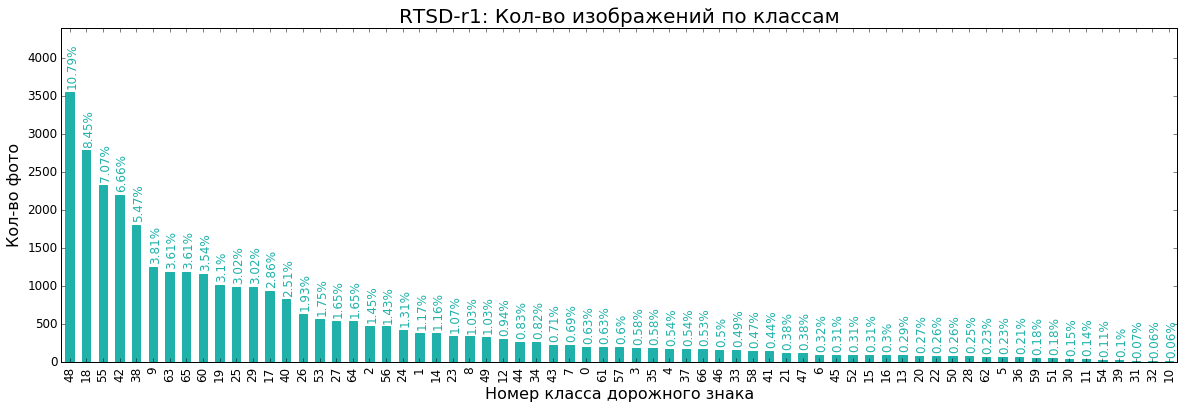

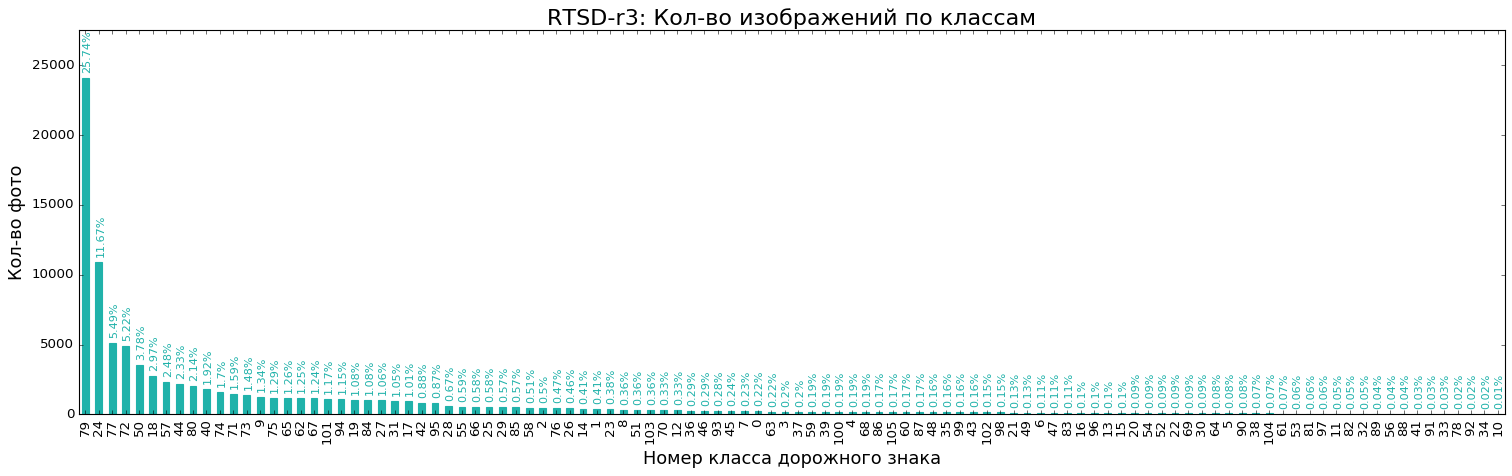

In [0]:
def plot_class_percent_bar(fig, series_class_counts, 
                           title: str, xlabel: str, ylabel: str, fig_name: str,
                           fontsize: int=12,
                           color='lightseagreen', edgecolor='lightseagreen'):
    plt.tight_layout()
    plt.style.use(['classic'])  # 'classic' | 'dark_background'
    fig.set_facecolor('w')
    
    bars = series_class_counts.plot.bar(color=color, edgecolor=edgecolor)

    totals = []
    for bar in bars.patches:
        # print(bar.get_width())
        totals.append(bar.get_height())
    total = sum(totals)

    ymin, ymax = bars.get_ylim()
    bars.set_ylim(top=ymax*1.1)

    # set individual bar lables using above list
    for bar in bars.patches:
        bar_height = bar.get_height()
        plt.text(bar.get_x(), bar_height + ymax*0.02,
                #  str(bar_height) + "(" + str(round((bar_height/total)*100, 2)) + "%)", 
                str(round((bar_height/total)*100, 2)) + "%",
                fontsize=fontsize, color=color, rotation=90)
        
    plt.title(title, color='k', fontsize=20)
    plt.xlabel(xlabel, color='k', fontsize=16)
    plt.ylabel(ylabel, color='k', fontsize=16)
    try:
        fig.savefig(fig_name)
        print(f"Сохранено в:{fig_name}")
    except:
        print('ERROR: Не удалось сохранить')

print("Кол-во классов знаков в R1: " + str(n_classes))  # -> 67
display(classes_names_df_r1.head(2))
display(classes_names_df_r1.tail(2))


fig = plt.figure(figsize=(20, 6))
title = 'RTSD-r1: Кол-во изображений по классам'
xlabel = 'Номер класса дорожного знака'
ylabel = 'Кол-во фото'
fig_name = results_path + '/r1_base.png'
plot_class_percent_bar(fig, r1_class_counts, title, xlabel, ylabel, fig_name)

# ------------------------------------------------------------------------------

r3_path = '/content/RTSD classification/rtsd-r3/'
classes_names_df_r3 = pd.read_csv(r3_path + 'numbers_to_classes.csv')
# classes_names_df_r3 = pd.ExcelFile(r3_path + 'numbers_to_classes.xlsx')
# classes_names_df_r3 = classes_names_df_r3.parse(sheet_name=0)
n_classes_r3 = classes_names_df_r3['class_number'].count()

print("Кол-во классов знаков в R3: " + str(n_classes_r3))  # -> 106
display(classes_names_df_r3.head(2))
display(classes_names_df_r3.tail(2))

labels_df_r3 = pd.ExcelFile(r3_path + 'gt_data.xlsx')
labels_df_r3 = labels_df_r3.parse(sheet_name=0)

labels_df_r3['filename'] = r3_path + 'train/' + labels_df_r3['filename']

r3_class_counts = labels_df_r3['class_number'].value_counts()

fig = plt.figure(figsize=(23, 6))
title = 'RTSD-r3: Кол-во изображений по классам'
xlabel = 'Номер класса дорожного знака'
ylabel = 'Кол-во фото'
fig_name = results_path + '/r3_base.png'
plot_class_percent_bar(fig, r3_class_counts, title, xlabel, ylabel, fig_name, fontsize=10)


<class 'matplotlib.container.BarContainer'>


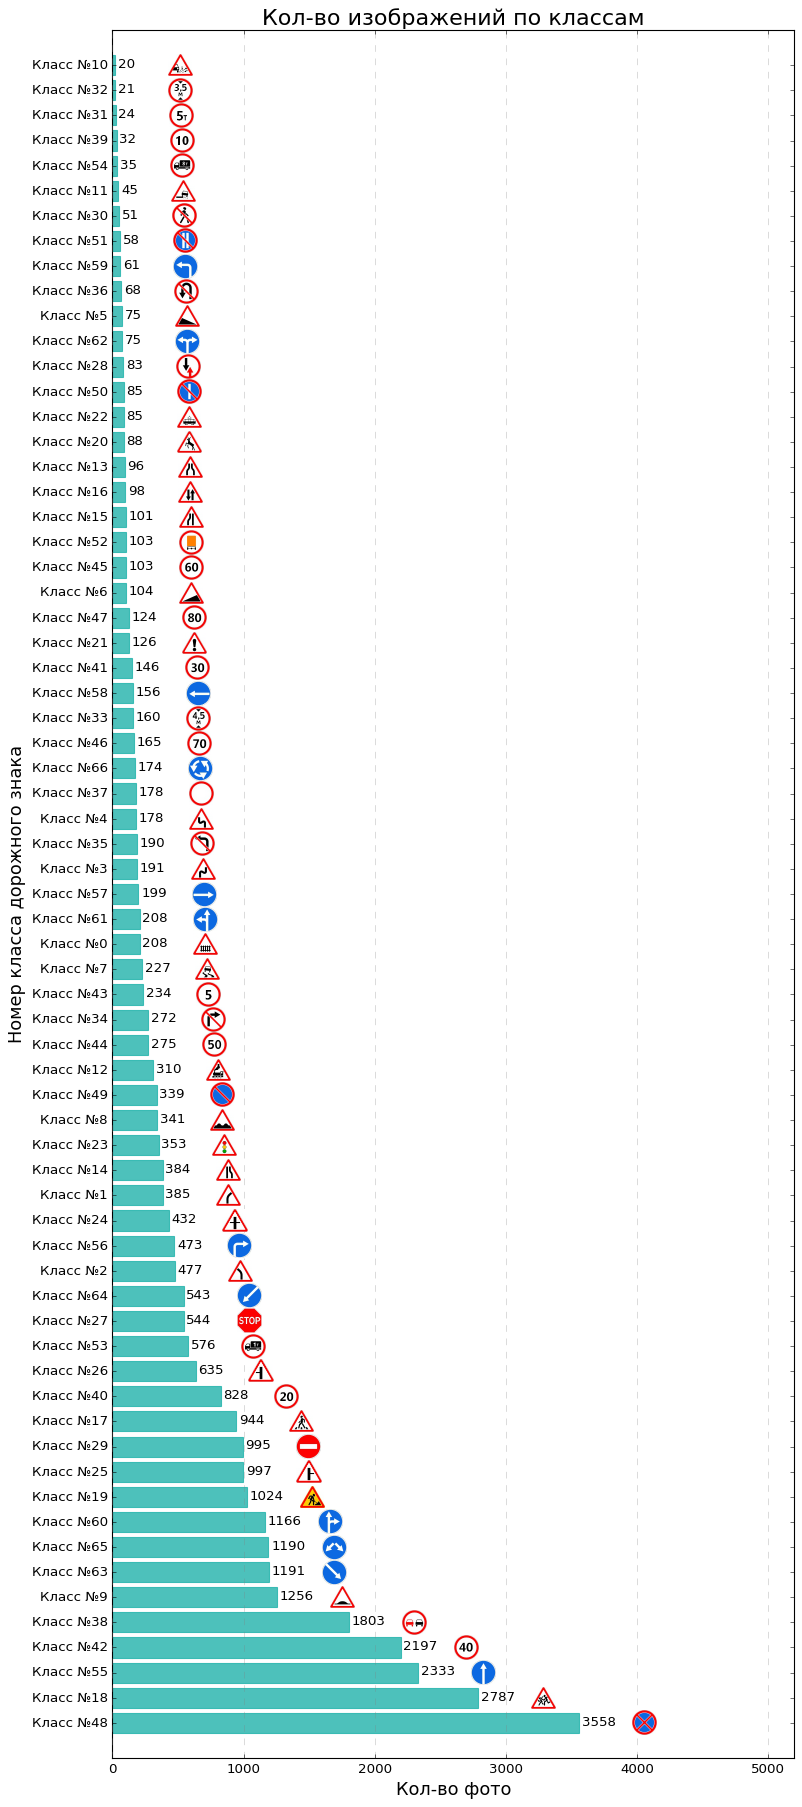

In [0]:
# from matplotlib.offsetbox import OffsetImage, AnnotationBbox
# import matplotlib.image as mpimg

orig_signs_folder_path = '/content/drive/My Drive/Colab Notebooks/Bases/signs_original'

# orig_signs_paths = (orig_signs_folder_path + '/' + 
                    # classes_names_df_r1['class_number'].astype(str) + '.jpg').to_numpy()
# y_bar_labels = ('Класс №' + classes_names_df_r1['class_number'].astype(str) + \
#                 " -> Знак " + classes_names_df_r1['sign_class'].astype(str) + \
#                 ':\n' + classes_names_df_r1['name'].astype(str)).to_numpy()

# получение pd.Series с индексами (номерами строк) в ввиде строчного типа (str)
y_bar_nums = r1_class_counts.index.astype(str)

y_bar_labels = (('Класс №' + y_bar_nums).to_numpy(dtype=str))
x_bar_labels = r1_class_counts.to_numpy()

fig, ax = plt.subplots(figsize=(11, 27))
plt.style.use(['classic'])
fig.set_facecolor('w')

bar_graphs = ax.barh(y_bar_labels, x_bar_labels, 0.8, 
                     edgecolor='lightseagreen', 
                     color='lightseagreen', alpha=0.8)
print(type(bar_graphs))

# сетка на графике по оси оХ
ax.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)

# увеличение масштаба по оси оХ вправа на 30%
xmin, xmax = ax.get_xlim()
ax.set_xlim((xmin, xmax*1.3))

ymin, ymax = ax.get_ylim()
ax.set_ylim(bottom=ymin-1, top=ymax+1)

for i, bar in enumerate(bar_graphs):
    # bar - это объект типа Rectangle
    w, h = bar.get_width(), bar.get_height()
    # координаты левой нижней вершины
    x0, y0 = bar.xy
    
    # отображение оригинальных фото дорожных знаков
    path = orig_signs_folder_path + '/' + y_bar_nums[i] + '.jpg'
    arr_img = mpimg.imread(path)
    imagebox = OffsetImage(arr_img, zoom=0.45)
    # центр изображения по Ох правее данного bar'a на 500 единиц, по оУ - посередине bar'a
    ab = AnnotationBbox(imagebox, (x0 + w + 500, y0 + h/2), frameon=False)
    ax.add_artist(ab)

    # отображение точного численного кол-во правее на 20 единиц от данного bar'a
    label = x_bar_labels[i]
    plt.text(x = x0 + w + 20 , y = y0 + h/2 - 0.1, s = label, size = 12)
    
plt.title('Кол-во изображений по классам', color='k', fontsize=20)
plt.ylabel('Номер класса дорожного знака', color='k', fontsize=16)
plt.xlabel('Кол-во фото', color='k', fontsize=16)
# plt.show()
fig_name = results_path + '/r1_fancy_bar.png'
fig.savefig(fig_name, dpi=300)

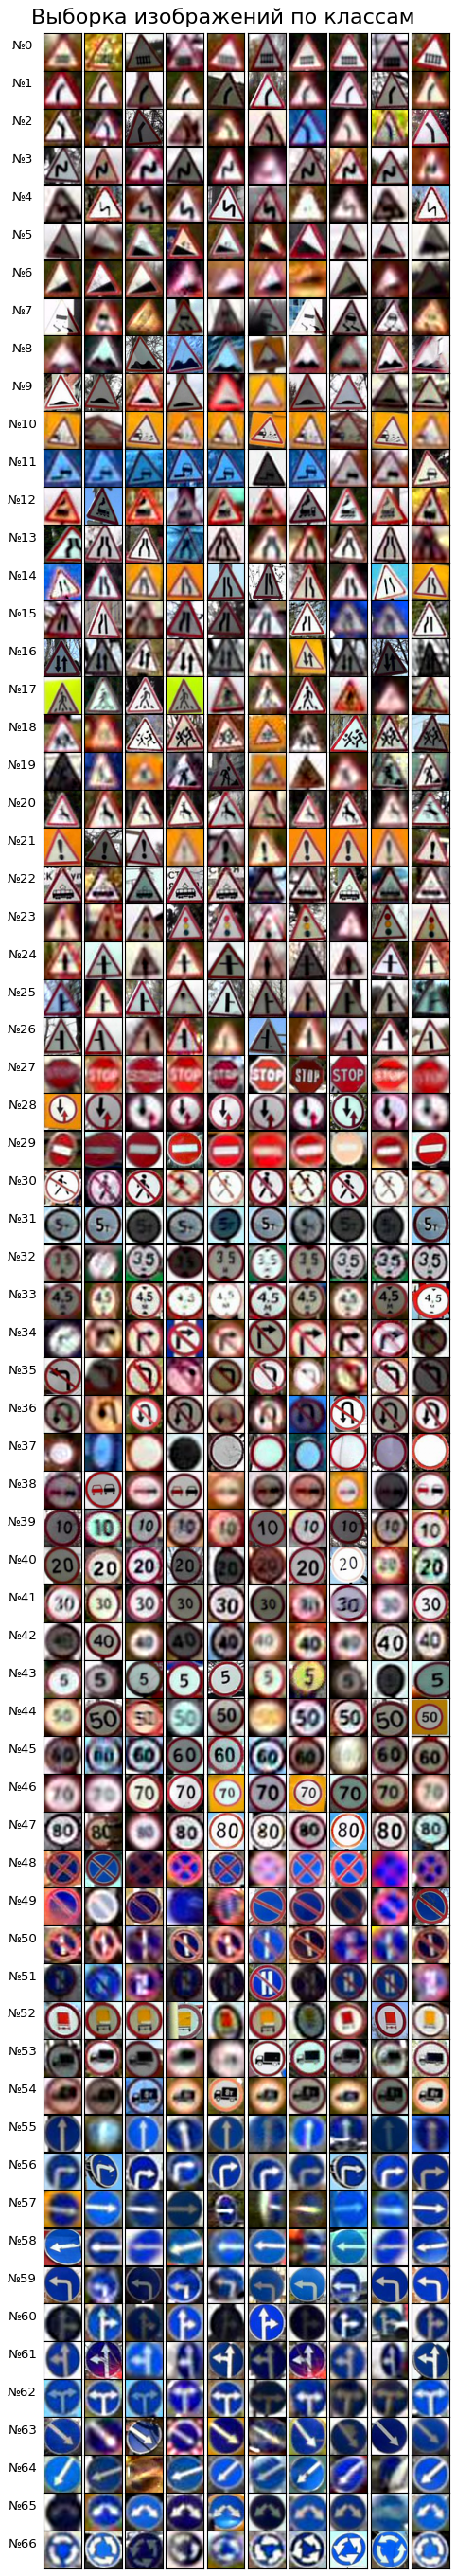

In [0]:
# ВИЗУАЛИЗАЦИЯ ДАННЫХ
n_samples = 10

fig = plt.figure(figsize=((n_samples + 2)*0.5, (n_classes + 2)*0.5))
fig.subplots_adjust(left=0.1, right=1, bottom=0, top=0.97, hspace=0.005, wspace=0.005)
plt.style.use(['classic'])
fig.set_facecolor('w')

for row_i in range(n_classes):

    # маска с фильтром класса с номером row_i
    temp_filter = labels_df["class_number"] == row_i
    
    # случайная выборка n_samples (кол-во) фото из отфильтрованного класса
    temp = labels_df.where(temp_filter)['filename'].dropna().sample(n=n_samples, random_state=1)

    # загрузка изображений отфильтрованных в массивы numpy.ndarray()
    temp_imgs = load_data(temp.to_numpy(), width, height, n_classes=n_classes)
    
    # print(temp_imgs[0].shape)
    for col_i in range(n_samples):
        ax = fig.add_subplot(n_classes, n_samples, 
                             row_i*10 + col_i + 1, xticks=[], yticks=[])
        
        # ax2 = fig2.add_subplot(n_classes, n_samples, 
        #                        row_i*10 + col_i + 1, xticks=[], yticks=[])

        
        ax.imshow(temp_imgs[col_i])
        # ax.imshow(temp_imgs[col_i], cmap='gray')
        # ax2.imshow(temp_imgs[col_i], cmap='gray')
 
        # если выводим перове изображение в (находится в левом столбце)
        if col_i == 0:
            row_text = '№' + str(row_i)
            # print(len(row_text))
            # labelpad необхидом выбрать вручную, чтобы текст не заходил на график
            # labelpad = len(row_text) * 8 -> не работает
            ax.set_ylabel(row_text, rotation=0, labelpad=20) 
            # ax2.set_ylabel(row_text, rotation=0, labelpad=40)

fig.suptitle('Выборка изображений по классам', color='k', fontsize=20)
# fig2.suptitle('Выборка изображений по классам с предобработкой', 
#               color='k', fontsize=20)
# plt.tight_layout()

fig_name = results_path + '/ImagesSamples.png'
fig.savefig(fig_name)

# fig_name2 = '/content/drive/My Drive/Colab Notebooks/Bases/ImagesSamples_cmap.png'
# fig.savefig(fig_name2, dpi=100)


In [0]:
height = 48
width = 48
channels = 3

imgs_paths = labels_df['filename'].to_numpy()
class_labels = labels_df['class_number'].to_numpy()

# Деление данных на train / validation / test datasets
train_X_paths, val_X_paths, train_X_targets, val_Y_targets = train_test_split(
        imgs_paths, class_labels,
        train_size=0.7,
        test_size=0.3,
        random_state=20,
        stratify=class_labels)

# val_X_paths, test_X_paths, val_Y_targets, test_Y_targets = train_test_split(
#         val_X_paths, val_Y_targets,
#         train_size=0.65,  # 0.3 * 0.65 = 0.195 | 0.3 * 0.8 = 0.24
#         test_size=0.35,  # 0.3 * 0.35 = 0.105 | 0.3 * 0.35 = 0.06
#         random_state=20,
#         stratify=val_Y_targets)
# # stratify позволяет выбрать переменную (класс знака), относительно которой 
# # необходимо выдержать пропорцию

train_percentages = np.bincount(train_X_targets) / (np.bincount(train_X_targets) + np.bincount(val_Y_targets))
test_percentages = np.bincount(val_Y_targets) / (np.bincount(train_X_targets) + np.bincount(val_Y_targets))

# plt.figure()
# plt.hist([x1,x2,x3], bins, stacked=True, density=True)
# plt.hist([train_percentages*100, test_percentages*100], 
        #  bins=np.arange(0, n_classes), stacked=True)


train_X, train_Y = load_data(train_X_paths, width, height, n_classes=n_classes,
                            num_labels=list(train_X_targets))
val_X, val_Y = load_data(val_X_paths, width, height, n_classes=n_classes,
                            num_labels=list(val_Y_targets))
# test_X, test_Y = load_data(test_X_paths, width, height, n_classes,
#                             num_labels=list(test_Y_targets))

print(
f'''
                        \tИзображения     \t-> \tМетки   
Обучающий набор данных: \t{train_X.shape} \t-> \t{train_Y.shape}
Валидационный набор данных: \t{val_X.shape} \t-> \t{val_Y.shape}''')
# Тестовый набор данных: \t\t{test_X.shape} \t-> \t{test_Y.shape}''')


# rtsd-r1/ -> (32983, 48, 48, 3) -> 1.7 GB
# rtsd-r3/ -> (93654, 48, 48, 3) -> 4.82 GB
# print(data.nbytes/1024**3)  # чтобы узнать вес массива в GB

# Исправление ошибок в validation dataset
to_change_label = {2: 49, 4: 1, 8: 1, 17: 26, 23: 1, 34: 15, 37: 1, 42: 26, 53: 15, 60: 1}
for index, label in to_change_label.items():
    ind = incorrect_classes[index-1]
    val_Y[ind] = to_categorical(label, num_classes=n_classes)

to_hor_flip = [0, 24, -33]
for index in to_hor_flip:
    ind = incorrect_classes[index]
    val_X[ind] = np.fliplr(val_X[ind])



                        	Изображения     	-> 	Метки   
Обучающий набор данных: 	(23088, 48, 48, 3) 	-> 	(23088, 67)
Валидационный набор данных: 	(9895, 48, 48, 3) 	-> 	(9895, 67)


NameError: ignored

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
import keras

input_shape = (height, width, channels)  # train_X.shape[1:] -> (48, 48, 3)
chan_dim = -1

model = Sequential()

# model.add(Conv2D(filters=16, kernel_size=(8,8), activation='relu', 
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))

# model.add(BatchNormalization(axis=chan_dim))
# model.add(Conv2D(filters=32, kernel_size=(4,4), activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization(axis=chan_dim))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.2))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization(axis=chan_dim))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization(axis=chan_dim))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# полносвязный слой №1
model.add(Flatten())
model.add(Dense(256, activation='relu'))
# model.add(Dense(128, activation='relu'))

model.add(BatchNormalization())
model.add(Dropout(0.5))

# полносвязный слой №2
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# softmax классификатор
model.add(Dense(n_classes, activation='softmax'))

model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

In [0]:
# Обучение №1. Оригинальные данные только из базы данных
# from keras.callbacks import ModelCheckpoint, EarlyStopping

# условие завершения обучения, чтобы избежать переобучения
es_callback = EarlyStopping(monitor='val_loss',  # наблюдаемая величина
                            patience=3,  # кол-во эпох, в которых не должно происходить улучшения
                            restore_best_weights=True)  # востановить веса наилучшей модели? -> True

# filepath=results_path + "/model-{epoch:02d}-{val_acc:.2f}.hdf5"
# filepath=results_path + "/Models/model-train1.hdf5"
filepath=results_path + "/Models/model-train1_new.hdf5"


checkpoint_callback = ModelCheckpoint(filepath=filepath,
                                      monitor='val_loss',
                                      save_best_only=True)

epochs = 100
history = model.fit(train_X, train_Y, batch_size=5000, epochs=epochs,
                    validation_data=(val_X, val_Y),
                    callbacks=[es_callback, checkpoint_callback])


Train on 23088 samples, validate on 9895 samples
Epoch 1/100
23088/23088 [==============================] - 7s 305us/step - loss: 3.7661 - acc: 0.2170 - val_loss: 1.9874 - val_acc: 0.5789
Epoch 2/100
23088/23088 [==============================] - 3s 147us/step - loss: 2.1422 - acc: 0.5191 - val_loss: 1.3750 - val_acc: 0.6885
Epoch 3/100
23088/23088 [==============================] - 3s 148us/step - loss: 1.6268 - acc: 0.6340 - val_loss: 1.0294 - val_acc: 0.7444
Epoch 4/100
23088/23088 [==============================] - 3s 149us/step - loss: 1.3399 - acc: 0.6926 - val_loss: 0.8188 - val_acc: 0.7949
Epoch 5/100
23088/23088 [==============================] - 3s 147us/step - loss: 1.1351 - acc: 0.7364 - val_loss: 0.6870 - val_acc: 0.8247
Epoch 6/100
23088/23088 [==============================] - 3s 146us/step - loss: 0.9852 - acc: 0.7687 - val_loss: 0.6026 - val_acc: 0.8427
Epoch 7/100
23088/23088 [==============================] - 3s 146us/step - loss: 0.8620 - acc: 0.7979 - val_loss: 0.5

In [0]:
# если необходимо загрузить сохраненную модель
from keras.models import  load_model

# model = load_model('/content/drive/My Drive/Colab Notebooks/Results/CourseWork/Models/model-train1.hdf5')
model = load_model('/content/drive/My Drive/Colab Notebooks/Results/CourseWork/Models/model-train1_new.hdf5')


In [0]:
def results_report(data_X, data_Y, save_xlsx_path: str="", batch_size: int=64):
    pred = model.predict(data_X, batch_size=batch_size, verbose=1)

    # Вектор-класс в номер класса: [0 0 1 0 ... 0] -> 2
    pred_bool = np.argmax(pred, axis=1)

    # Словарь с данными о результатах
    report = classification_report(np.argmax(data_Y, axis=1), pred_bool, 
                                   output_dict=True)
    # Создание 
    report_df = pd.DataFrame(report).transpose()

    if save_xlsx_path:
        try:
            report_df.to_excel(save_xlsx_path, sheet_name='Sheet0')
            print(f"Сохранено в:{save_xlsx_path}")
        except:
            print('ERROR: Не удалось сохранить')

    return report_df

In [0]:
# Визуализация обучения №1

# fig0 = plt.figure(0)
# plt.plot(history.history['acc'], label='Точность обучения (Train acc)')
# plt.plot(history.history['val_acc'], label='Точность валидации (Val acc)')

# plt.style.use(['classic'])
# fig0.set_facecolor('w')
# plt.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)
# plt.title('Точность классификации в процессе обучения', fontsize=18)
# plt.xlabel('Эпоха', fontsize=14)
# plt.ylabel('Точность', fontsize=14)
# plt.legend(loc='best')
# fig0.savefig(results_path + '/train1_acc_per_epochs.png')

# # --------------

# fig1 = plt.figure(1)
# plt.plot(history.history['loss'], label='Loss-функция обучения (train)')
# plt.plot(history.history['val_loss'], label='Loss-функция валидации (val)')

# plt.style.use(['classic'])
# fig1.set_facecolor('w')
# plt.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)
# plt.title('Loss-функции в процессе обучения', fontsize=18)
# plt.xlabel('Эпоха', fontsize=14)
# plt.ylabel('Значение Loss-функции', fontsize=14)
# plt.legend(loc='best')
# fig1.savefig(results_path + '/train1_loss_per_epochs.png')

# ---------------
# ---------------


# на ВАЛИДАЦИОННОМ ДАТАСЕТЕ
val_report_df = results_report(val_X, val_Y, save_xlsx_path=results_path + 
                               '/train1_val_report.xlsx')
print(val_report_df)
val_eval = model.evaluate(val_X, val_Y)
print(f'loss: {round(val_eval[0], 5)}, acc: {round(val_eval[1], 5)}')

# на ТЕСТОВОМ ДАТАСЕТЕ
# test_report_df = results_report(test_X, test_Y, save_xlsx_path=results_path + 
#                                '/train1_test_report.xlsx')
# print(test_report_df)
# test_eval = model.evaluate(test_X, test_Y)
# print(f'loss: {round(test_eval[0], 5)}, acc: {round(test_eval[1], 5)}')

9895/9895 [==============================] - 7s 705us/step
Сохранено в:/content/drive/My Drive/Colab Notebooks/Results/CourseWork/train1_val_report.xlsx
              precision    recall  f1-score      support
0              0.964912  0.887097  0.924370    62.000000
1              0.957265  0.965517  0.961373   116.000000
2              0.912752  0.951049  0.931507   143.000000
3              0.982143  0.964912  0.973451    57.000000
4              0.961538  0.943396  0.952381    53.000000
...                 ...       ...       ...          ...
65             0.978022  0.997199  0.987517   357.000000
66             0.960000  0.923077  0.941176    52.000000
accuracy       0.979889  0.979889  0.979889     0.979889
macro avg      0.981640  0.946133  0.961841  9895.000000
weighted avg   0.980145  0.979889  0.979694  9895.000000

[70 rows x 4 columns]
9895/9895 [==============================] - 1s 146us/step
loss: 0.08226, acc: 0.97989


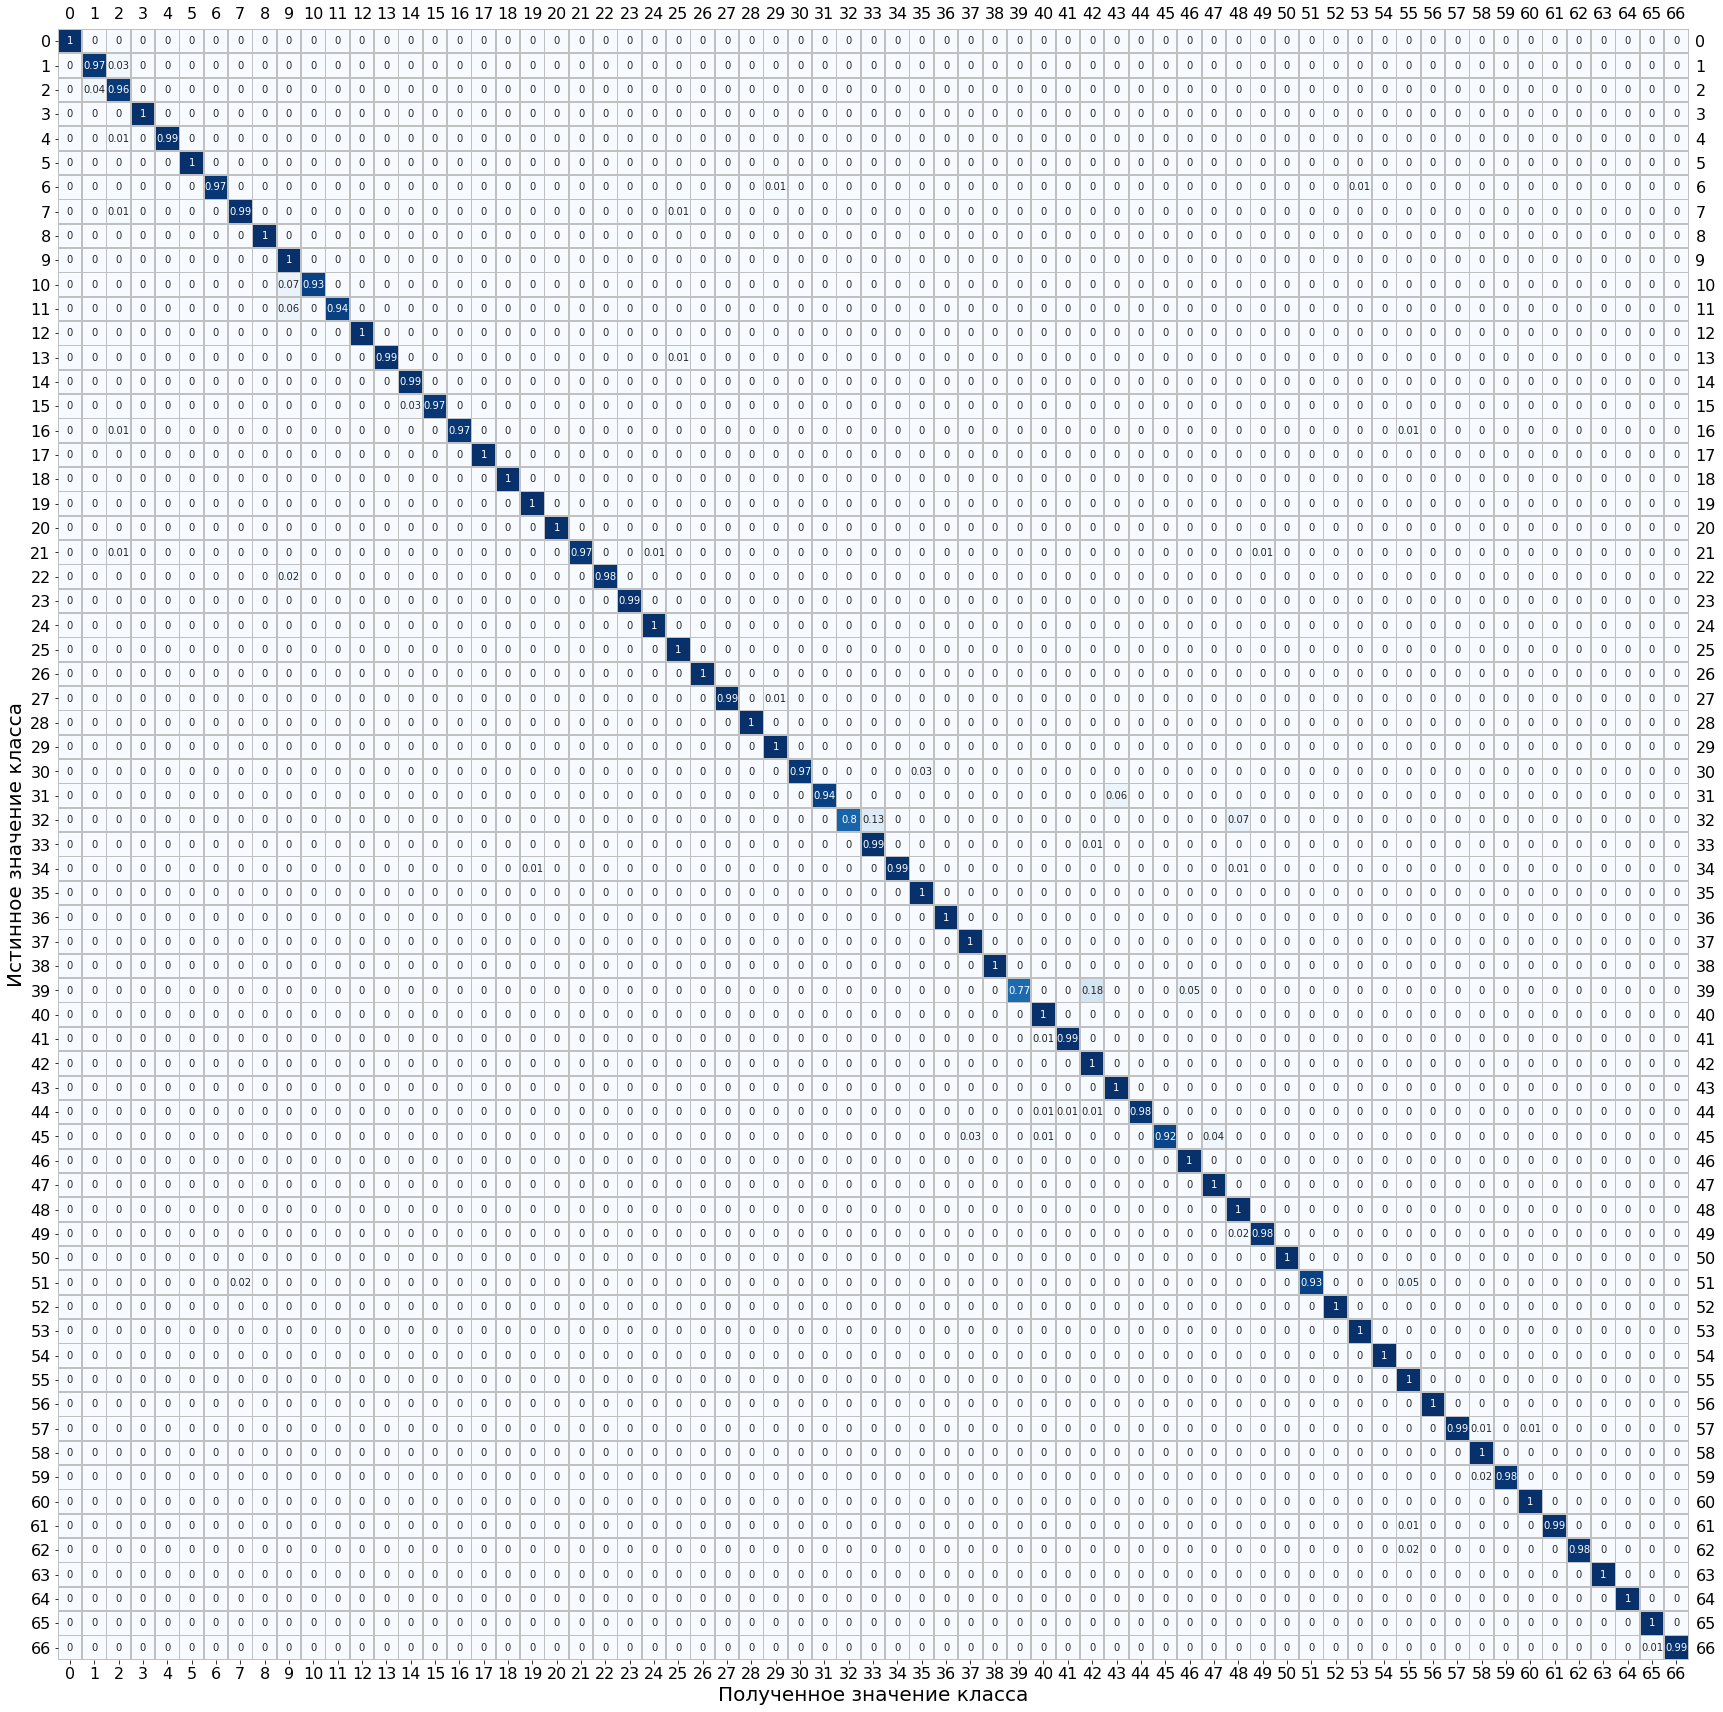

In [0]:
# import sklearn.metrics as metrics
# import seaborn as sb
# y_pred = model.predict_classes(test_X)
# test_Y_classes = np.argmax(test_Y, axis=1)  # to_categorical() -> class_number
y_pred = model.predict_classes(train_X)
test_Y_classes = np.argmax(train_Y, axis=1)  # to_categorical() -> class_number

con_mat1 = metrics.confusion_matrix(y_true=test_Y_classes, y_pred=y_pred)
con_mat_norm1 = np.around(con_mat1.astype('float') / con_mat1.sum(axis=1)[:, np.newaxis], decimals=2)
 
con_mat_df1 = pd.DataFrame(con_mat_norm1, index = range(n_classes), 
                          columns = range(n_classes))

# sb.set_style(ytick.left=True, ytick.right=True)
fig = plt.figure(figsize=(30, 30))
ax = sb.heatmap(con_mat_df1, square=True,
                 annot=True, linecolor='silver',
                 # center=0,
                 cmap=plt.cm.Blues,
                 # cmap="vlag",
                 linewidths=0.75,
                 cbar=False)

ax.tick_params(labelright=True, left=True, bottom=True, labeltop=True, 
               rotation=0, labelsize=16)
# plt.tight_layout()
plt.ylabel('Истинное значение класса', fontsize=20)
plt.xlabel('Полученное значение класса', fontsize=20)
fig.savefig(results_path + '/train1_confusion_matrix.png')


Text(0.5, 0.98, 'Полученное значение класса')

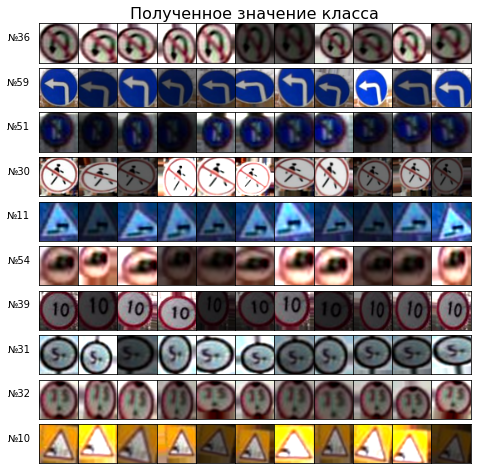

In [0]:
from keras.preprocessing.image import ImageDataGenerator

# так как используется brightness_range, то изображения на выходе будут иметь
# масштаб [0, 255]. Необходимо вернуться к обратному масштабу
def rescaling_func(image):
    return image/255

datagen = ImageDataGenerator(
    rotation_range=8,
	zoom_range=[0.8, 1.2],
	width_shift_range=0.12,
	height_shift_range=0.12,
    brightness_range=[0.3, 1.7],
	fill_mode="nearest",
    preprocessing_function=rescaling_func)  # применяется после всех преобразований

n_class_examples = 10
n_samples = 10

# выбор n_class_examples-классов с наименьшим кол-вом изображений в базе данных
temp_classes = r1_class_counts.tail(n_class_examples).index.to_numpy()

# случайный выбор n_class_examples-классов
# temp_classes = labels_df["class_number"].sample(n=n_class_examples, 
#                                                 random_state=3).to_numpy()

fig, axes = plt.subplots(nrows=n_class_examples, ncols=n_samples+1,
                         figsize=((n_samples + 2)*0.5, (n_class_examples + 1 + 2)*0.5))
                        #  xticks=[], yticks=[])

fig.subplots_adjust(left=0, right=1, bottom=0, top=0.95, hspace=0.01, wspace=0)
plt.style.use(['classic'])
fig.set_facecolor('w')

for row_i in range(n_class_examples):

    temp_filter = labels_df["class_number"] == temp_classes[row_i]
    temp = labels_df.where(temp_filter)['filename'].dropna().sample(n=1, random_state=1)
    temp_imgs = load_data(temp.to_numpy(), width, height, n_classes)

    aug_iterator = datagen.flow(temp_imgs, batch_size=n_samples)

    for col_i in range(0, n_samples+1):
        ax = axes[row_i, col_i]
        ax.set_xticks([])
        ax.set_yticks([])
        
        # если выводим перове изображение (находится в левом столбце)
        if col_i == 0:
            # оригинальной изображения
            ax.imshow(temp_imgs[0])
            row_text = '№' + str(temp_classes[row_i])
            ax.set_ylabel(row_text, rotation=0, labelpad=20)

        else:
            aug_img = aug_iterator.next()
            ax.imshow(aug_img[0])

plt.suptitle('Полученное значение класса', fontsize=16)
# fig.savefig(results_path + '/data_augumentation_example.png')

In [0]:
# условие завершения обучения, чтобы избежать переобучения
es_callback = EarlyStopping(monitor='val_loss',  # наблюдаемая величина
                            patience=2,  # кол-во эпох, в которых не должно происходить улучшения
                            restore_best_weights=True)  # востановить веса наилучшей модели? -> True

# filepath=results_path + "/model-{epoch:02d}-{val_acc:.2f}.hdf5"
# filepath=results_path + "/Models/model-train2_new.hdf5"
filepath=results_path + "/Models/model-train2_new.hdf5"

checkpoint_callback = ModelCheckpoint(filepath=filepath,
                                      monitor='val_loss',
                                      save_best_only=True)

epochs = 15   
# epochs = 1
history2 = model.fit_generator(datagen.flow(train_X, train_Y, batch_size=16),
                    steps_per_epoch=train_X.shape[0],
                    epochs=epochs,
                    validation_data=(val_X, val_Y),
                    callbacks=[checkpoint_callback, es_callback])


Epoch 1/15
23088/23088 [==============================] - 514s 22ms/step - loss: 0.5474 - acc: 0.8517 - val_loss: 0.0630 - val_acc: 0.9822
Epoch 2/15
23088/23088 [==============================] - 508s 22ms/step - loss: 0.2535 - acc: 0.9306 - val_loss: 0.0501 - val_acc: 0.9851
Epoch 3/15
23088/23088 [==============================] - 502s 22ms/step - loss: 0.1954 - acc: 0.9457 - val_loss: 0.0299 - val_acc: 0.9918
Epoch 4/15
23088/23088 [==============================] - 500s 22ms/step - loss: 0.1634 - acc: 0.9542 - val_loss: 0.0295 - val_acc: 0.9914
Epoch 5/15
23088/23088 [==============================] - 515s 22ms/step - loss: 0.1415 - acc: 0.9602 - val_loss: 0.0256 - val_acc: 0.9929
Epoch 6/15
23088/23088 [==============================] - 533s 23ms/step - loss: 0.1293 - acc: 0.9634 - val_loss: 0.0227 - val_acc: 0.9932
Epoch 7/15
23088/23088 [==============================] - 520s 23ms/step - loss: 0.1185 - acc: 0.9667 - val_loss: 0.0241 - val_acc: 0.9931
Epoch 8/15
23088/23088 [===

In [0]:
filepath=results_path + "/Models/model-train2_1_new.hdf5"

es_callback = EarlyStopping(monitor='val_loss',  # наблюдаемая величина
                            patience=2,  # кол-во эпох, в которых не должно происходить улучшения
                            restore_best_weights=True) 

checkpoint_callback = ModelCheckpoint(filepath=filepath,
                                      monitor='val_loss',
                                      save_best_only=True)

epochs = 5    
# epochs = 1
history3 = model.fit_generator(datagen.flow(train_X, train_Y, batch_size=16),
                    steps_per_epoch=train_X.shape[0],
                    epochs=epochs,
                    validation_data=(val_X, val_Y),
                    callbacks=[checkpoint_callback, es_callback])

In [0]:
# print(type(history3.history['acc']))
# print(history2.history['acc'].append(history3.history['acc']))
# history2.history['acc'] = history2.history['acc'][0:5]
# history2.history['val_acc'] = history2.history['val_acc'][0:-len(history3.history['val_acc'])]
# history2.history['loss'].extend(history3.history['loss'])
# history2.history['loss'] = history2.history['loss'][0:-len(history3.history['val_loss'])]
# history2.history['val_loss'].extend(history3.history['val_loss'])
# history2.history['loss'].extend(history3.history['val_loss'])

# print(history2.history['acc'])
# print(history2.history['val_acc'])
# print(history2.history['loss'])
# print(history2.history['val_loss'])

from keras.models import  load_model

model = load_model('/content/drive/My Drive/Colab Notebooks/Results/CourseWork/Models/model-train2_1.hdf5')













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
y_pred = model.predict_classes(val_X)

acc = np.mean(y_pred == np.argmax(val_Y, axis=1))
print("Test accuracy = {}".format(acc))
# Test accuracy = 0.9923193532086912

# после исправления ошибочных данных
# Test accuracy = 0.9926225366346639
test_eval = model.evaluate(val_X, val_Y)
print(f'loss: {round(test_eval[0], 5)}, acc: {round(test_eval[1], 5)}')

Test accuracy = 0.9923193532086912
9895/9895 [==============================] - 1s 142us/step
loss: 0.02879, acc: 0.99232


6431/6431 [==============================] - 1s 84us/step
Сохранено в:/content/drive/My Drive/Colab Notebooks/Results/CourseWork/train2_val_report.xlsx
              precision    recall  f1-score      support
0              1.000000  0.925000  0.961039    40.000000
1              0.937500  1.000000  0.967742    75.000000
2              1.000000  0.935484  0.966667    93.000000
3              1.000000  1.000000  1.000000    37.000000
4              1.000000  1.000000  1.000000    34.000000
...                 ...       ...       ...          ...
65             0.991453  1.000000  0.995708   232.000000
66             1.000000  1.000000  1.000000    34.000000
accuracy       0.992536  0.992536  0.992536     0.992536
macro avg      0.991897  0.982993  0.987054  6431.000000
weighted avg   0.992640  0.992536  0.992497  6431.000000

[70 rows x 4 columns]
6431/6431 [==============================] - 1s 118us/step
loss: 0.02771, acc: 0.99254
3464/3464 [==============================] - 0s 84us/s

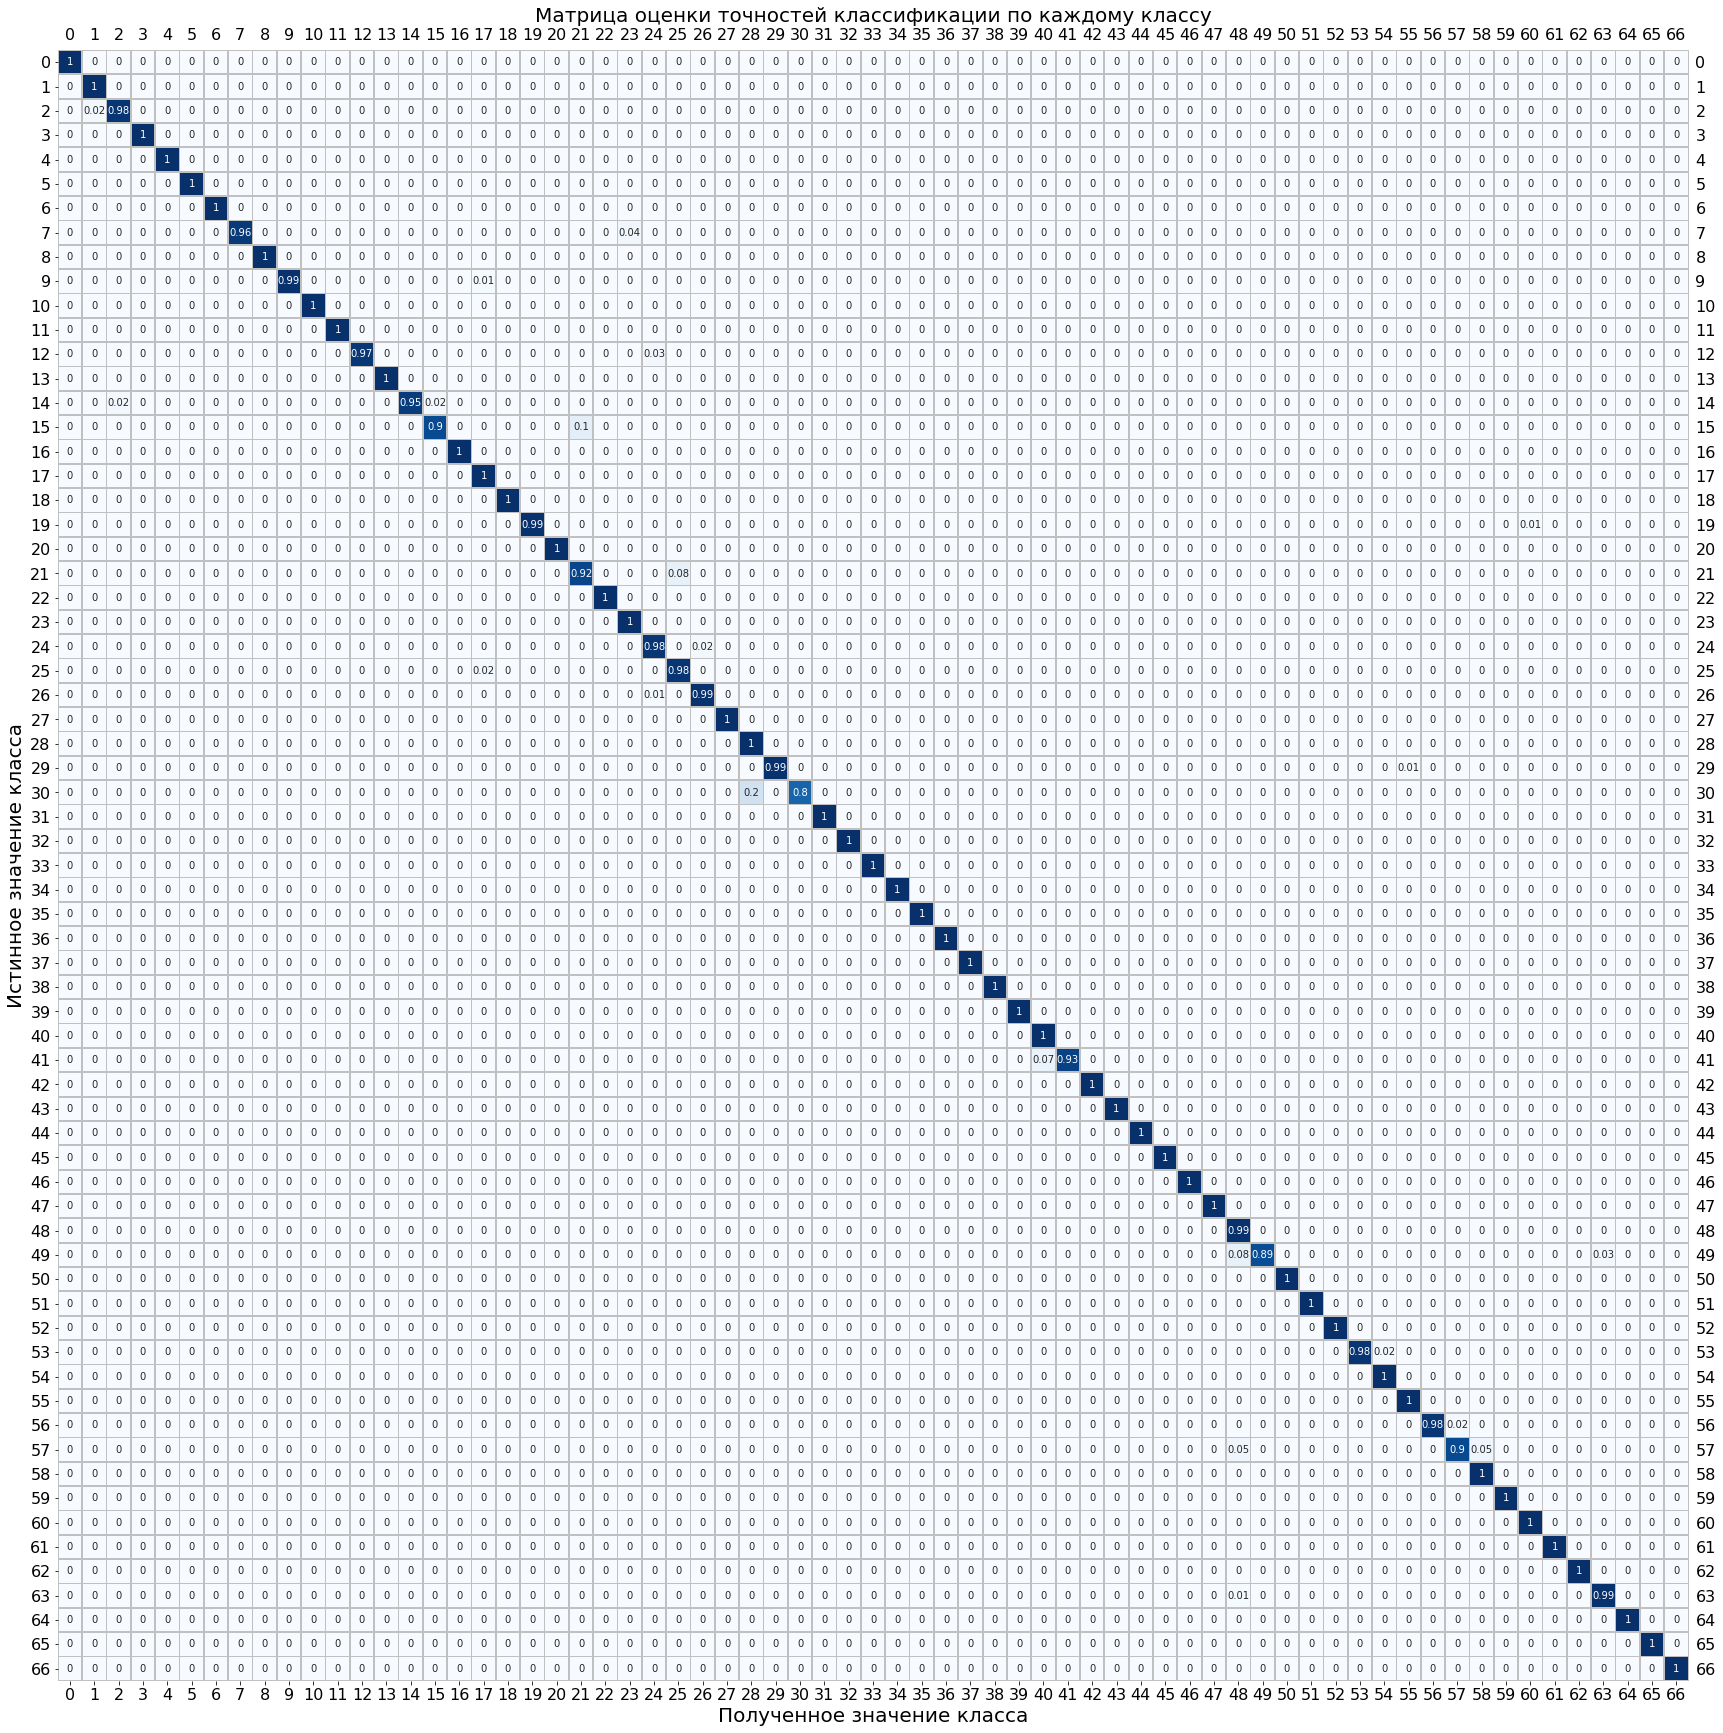

In [0]:
# fig2 = plt.figure(2)
# plt.plot(history2.history['acc'], label='Точность обучения (Train acc)')
# plt.plot(history2.history['val_acc'], label='Точность валидации (Val acc)')

# plt.style.use(['classic'])
# fig2.set_facecolor('w')
# plt.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)
# plt.title('Точность классификации в процессе обучения', fontsize=18)
# plt.xlabel('Эпоха', fontsize=14)
# plt.ylabel('Точность', fontsize=14)
# plt.legend(loc='best')
# fig2.savefig(results_path + '/train2_acc_per_epochs.png')

# # --------------

# fig3 = plt.figure(3)
# plt.plot(history2.history['loss'], label='Loss-функция обучения (train)')
# plt.plot(history2.history['val_loss'], label='Loss-функция валидации (val)')

# plt.style.use(['classic'])
# fig3.set_facecolor('w')
# plt.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)
# plt.title('Loss-функции в процессе обучения', fontsize=18)
# plt.xlabel('Эпоха', fontsize=14)
# plt.ylabel('Значение Loss-функции', fontsize=14)
# plt.legend(loc='best')
# fig3.savefig(results_path + '/train2_loss_per_epochs.png')

# ---------------
# ---------------

# на ВАЛИДАЦИОННОМ ДАТАСЕТЕ
val_report_df = results_report(val_X, val_Y, save_xlsx_path=results_path + 
                               '/train2_val_report.xlsx')
print(val_report_df)
val_eval = model.evaluate(val_X, val_Y)
print(f'loss: {round(val_eval[0], 5)}, acc: {round(val_eval[1], 5)}')

# на ТЕСТОВОМ ДАТАСЕТЕ
test_report_df = results_report(test_X, test_Y, save_xlsx_path=results_path + 
                               '/train2_test_report.xlsx')
print(test_report_df)
test_eval = model.evaluate(test_X, test_Y)
print(f'loss: {round(test_eval[0], 5)}, acc: {round(test_eval[1], 5)}')

# ----------------

y_pred = model.predict_classes(test_X)
test_Y_classes = np.argmax(test_Y, axis=1)  # to_categorical() -> class_number
# y_pred = model.predict_classes(train_X)
# test_Y_classes = np.argmax(train_Y, axis=1)  # to_categorical() -> class_number

con_mat2 = metrics.confusion_matrix(y_true=test_Y_classes, y_pred=y_pred)
con_mat_norm2 = np.around(con_mat2.astype('float') / con_mat2.sum(axis=1)[:, np.newaxis], decimals=2)
 
con_mat_df2 = pd.DataFrame(con_mat_norm2, index = range(n_classes), 
                          columns = range(n_classes))

fig = plt.figure(figsize=(30, 30))
fig.set_facecolor('w')
ax = sb.heatmap(con_mat_df2, square=True,
                 annot=True, linecolor='silver',
                 # center=0,
                 cmap=plt.cm.Blues,
                 # cmap="vlag",
                 linewidths=0.75,
                 cbar=False)
ax.tick_params(labelright=True, left=True, bottom=True, labeltop=True, 
               rotation=0, labelsize=16)
# plt.tight_layout()/
plt.title('Матрица оценки точностей классификации по каждому классу', fontsize=20)
plt.ylabel('Истинное значение класса', fontsize=20)
plt.xlabel('Полученное значение класса', fontsize=20)
fig.savefig(results_path + '/train2_confusion_matrix.png')

In [0]:
model.summary()
# from keras.utils import plot_model

# plot_model(model, to_file=results_path + '/model_2_1.png',
#            show_shapes=True)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 41, 41, 16)        3088      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 38, 38, 32)        8224      
_________________________________________________________________
batch_normalization_21 (Batc (None, 38, 38, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 19, 19, 32)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 19, 19, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 17, 17, 64)        18496     
_________________________________________________________________
batch_normalization_22 (Batc (None, 17, 17, 64)       

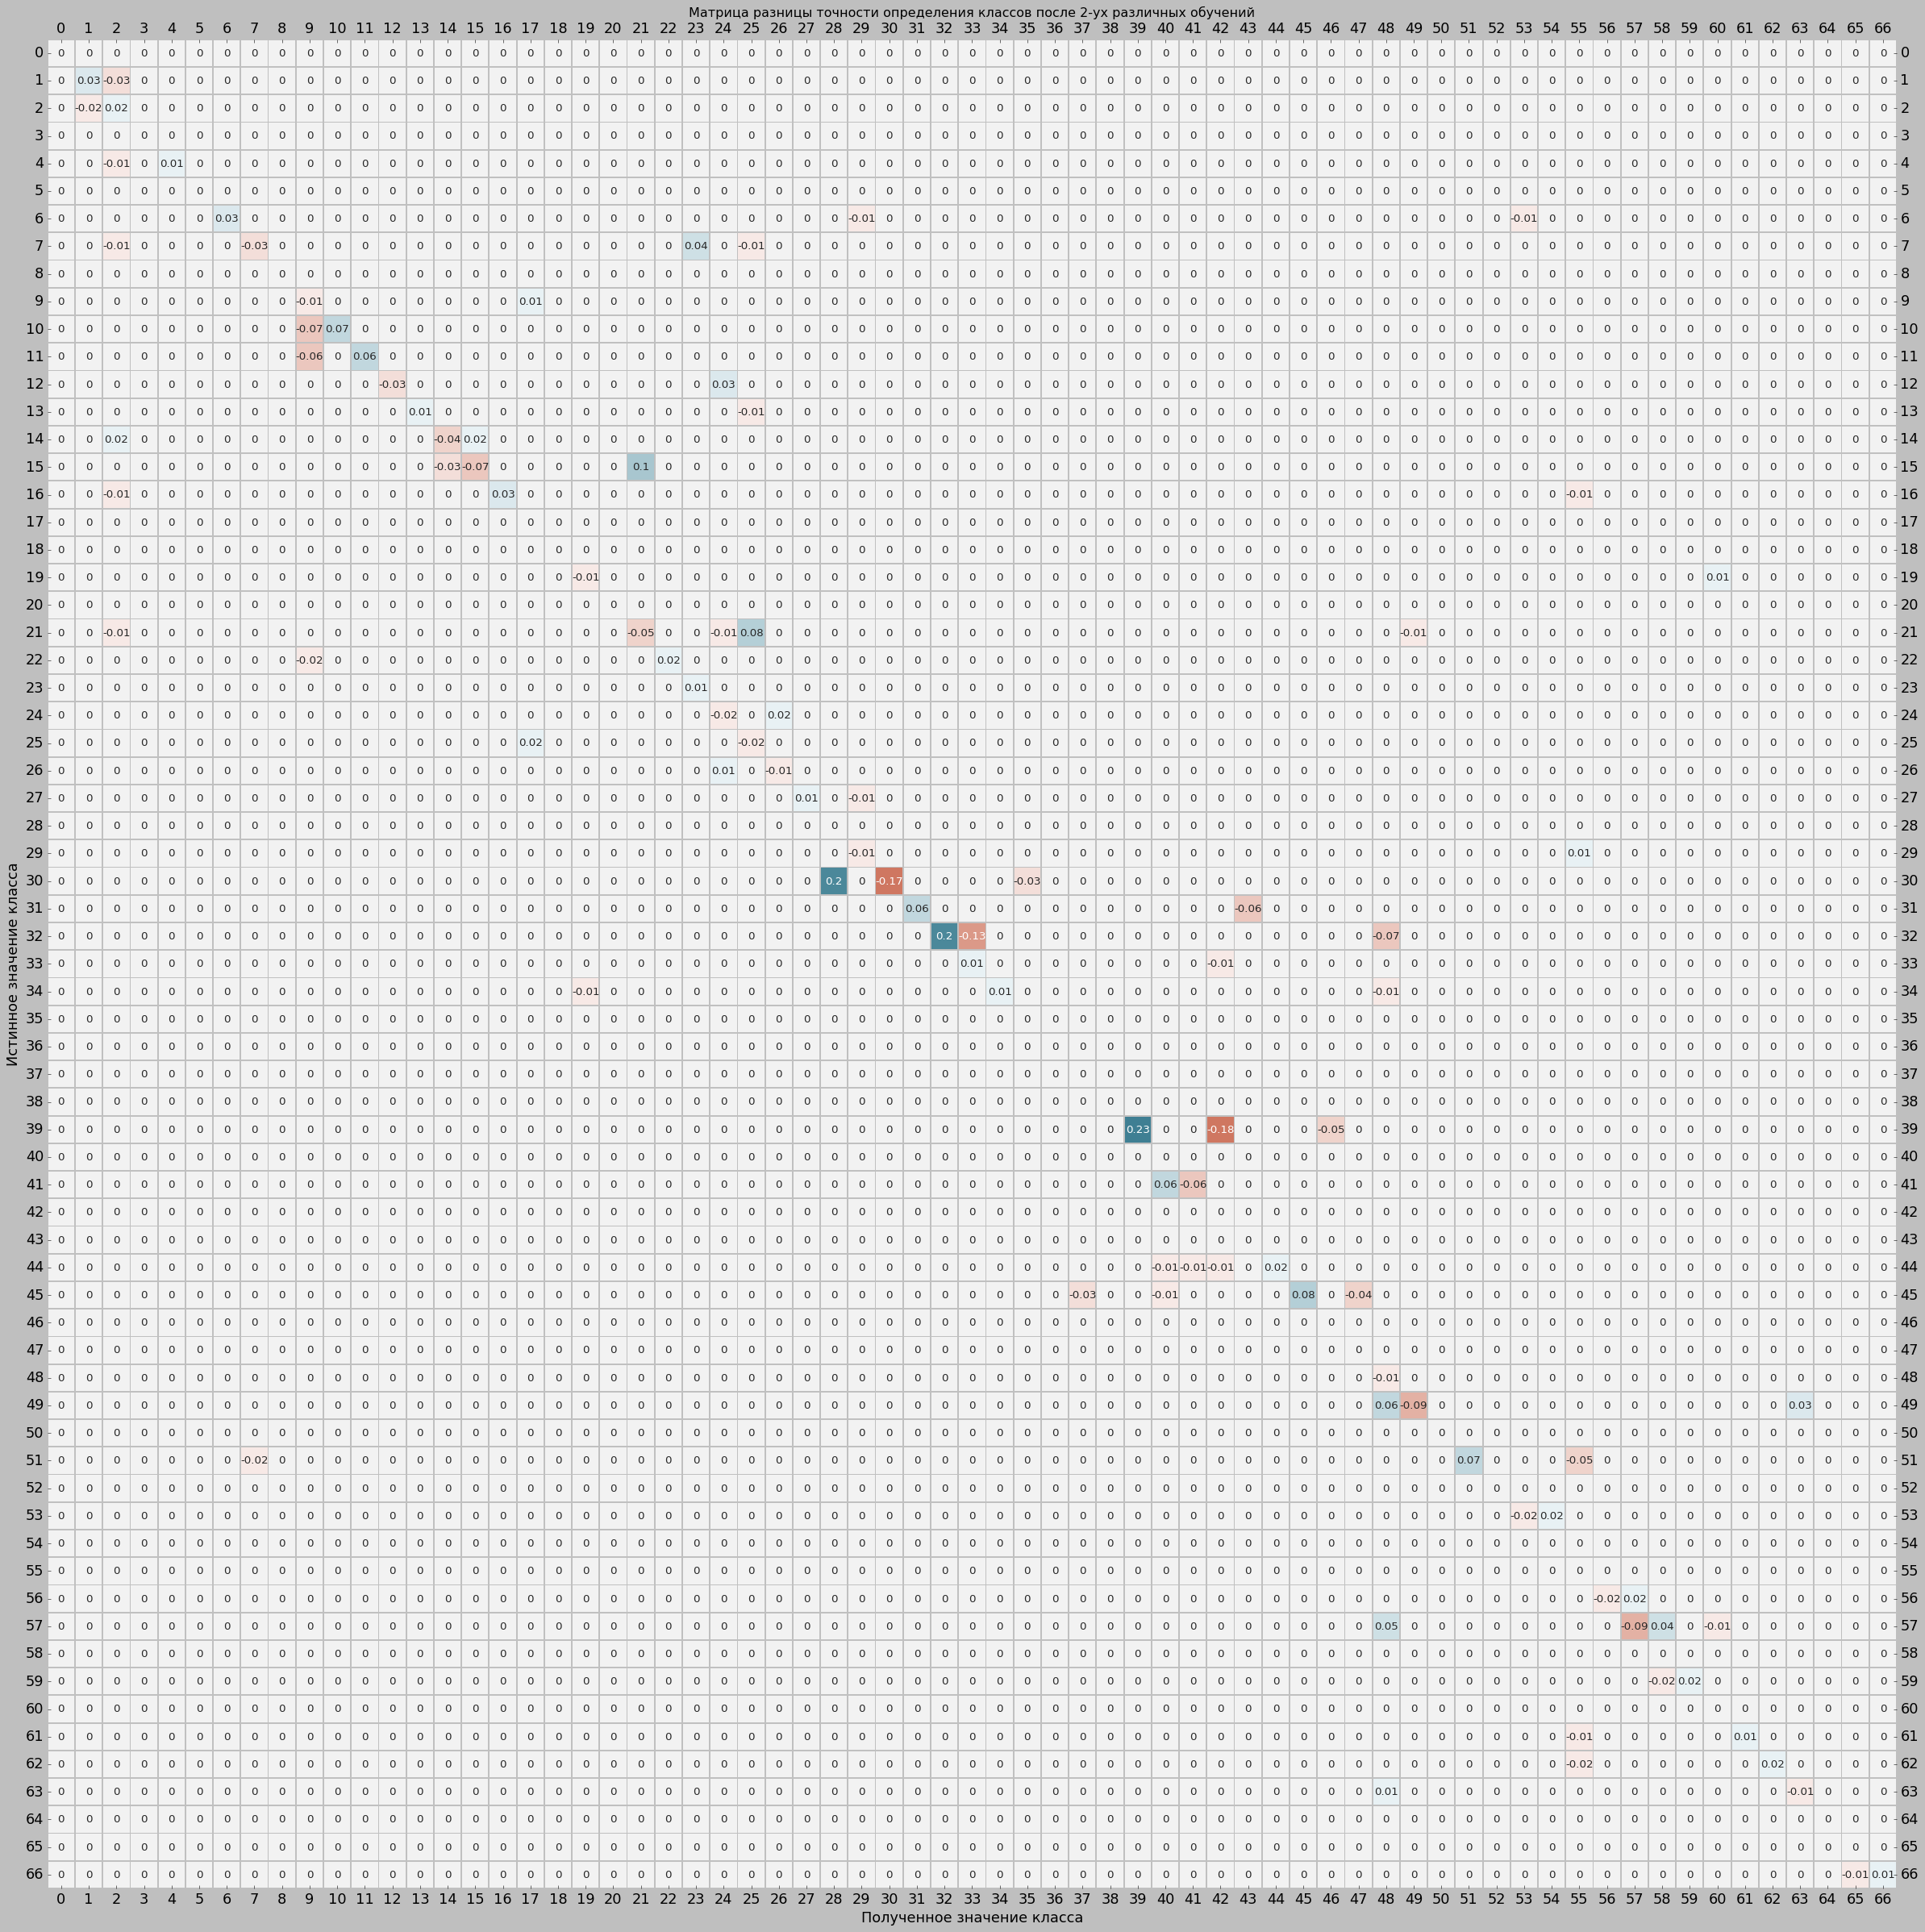

In [0]:
con_mat_norm_diff = con_mat_norm2 - con_mat_norm1
con_mat_df_diff = pd.DataFrame(con_mat_norm_diff, index = range(n_classes), 
                          columns = range(n_classes))

# sb.set_style(ytick.left=True, ytick.right=True)
fig = plt.figure(figsize=(30, 30))
ax = sb.heatmap(con_mat_df_diff, square=True,
                 annot=True, linecolor='silver',
                 center=0,
                #  cmap='coolwarm',
                cmap=sb.diverging_palette(20, 220, n=29),
                 # cmap="vlag",
                 linewidths=0.75,
                 cbar=False)

ax.tick_params(labelright=True, left=True, bottom=True, labeltop=True, 
               rotation=0, labelsize=16)
plt.ylabel('Истинное значение класса', fontsize=16)
plt.xlabel('Полученное значение класса', fontsize=16)
plt.title('Матрица разницы точности определения классов после 2-ух различных обучений')
plt.tight_layout()

fig.savefig(results_path + '/trains_diff_confusion_matrix.png')


In [0]:
def plot_fancy_signs_bar(df_classes, orig_signs_folder_path, ax, xlims,
                         zoom: int=0.45, delta_w: int=500, 
                         labels_fontsize: int=16, x_increase=1.3, 
                         green_condition: list=[]):
    # plt.style.use(['classic'])
    # fig.set_facecolor('w')

    # r1_class_counts
    y_bar_nums = df_classes.index.astype(str)

    if green_condition:
        colors = []
        edgecolors = []
        for i, bar_num in enumerate(y_bar_nums):
            
            if green_condition[0] == int(bar_num):
                colors.append('lightseagreen')
                edgecolors.append('lightseagreen')
            else:
                colors.append('tomato')
                edgecolors.append('tomato')

    else:
        colors = 'lightseagreen'
        edgecolors = 'lightseagreen'

    
    y_bar_labels = (('№' + y_bar_nums).to_numpy(dtype=str))

    x_bar_labels = df_classes[0].to_numpy()
    # print(x_bar_labels)
    # print(x_bar_labels.shape)

    bar_graphs = ax.barh(y_bar_labels, x_bar_labels, 0.8, 
                     edgecolor=edgecolors, 
                     color=colors, alpha=0.8)

    # сетка на графике по оси оХ
    ax.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)

    # увеличение масштаба по оси оХ вправа на 30%
    # xmin, xmax = ax.get_xlim()
    # ax.set_xlim((xmin, xmax*x_increase))
    ax.set_xlim((xlims[0], xlims[1]*x_increase))
    

    ymin, ymax = ax.get_ylim()
    ax.set_ylim(bottom=ymin-1, top=ymax+1)

    for i, bar in enumerate(bar_graphs):
        # bar - это объект типа Rectangle
        w, h = bar.get_width(), bar.get_height()
        # координаты левой нижней вершины
        x0, y0 = bar.xy

        # отображение оригинальных фото дорожных знаков
        path = orig_signs_folder_path + '/' + y_bar_nums[i] + '.jpg'
        arr_img = mpimg.imread(path)
        imagebox = OffsetImage(arr_img, zoom=zoom)
        # центр изображения по Ох правее данного bar'a на 500 единиц, по оУ - посередине bar'a
        # print(x0 + w + delta_w)
        ab = AnnotationBbox(imagebox, (x0 + w + delta_w, y0 + h/2), frameon=False)
        ax.add_artist(ab)

        label = round(x_bar_labels[i]*100, 3)
        # print(type(label))
        ax.text(x = x0 + w + 0.01, y = y0 + h/4, s = label, size = 12)
    
    # plt.title('Кол-во изображений по классам', color='k', fontsize=labels_fontsize)
    # plt.ylabel('Номер класса дорожного знака', color='k', fontsize=labels_fontsize)
    # plt.xlabel('Вероятность определения', color='k', fontsize=labels_fontsize)

ValueError: ignored

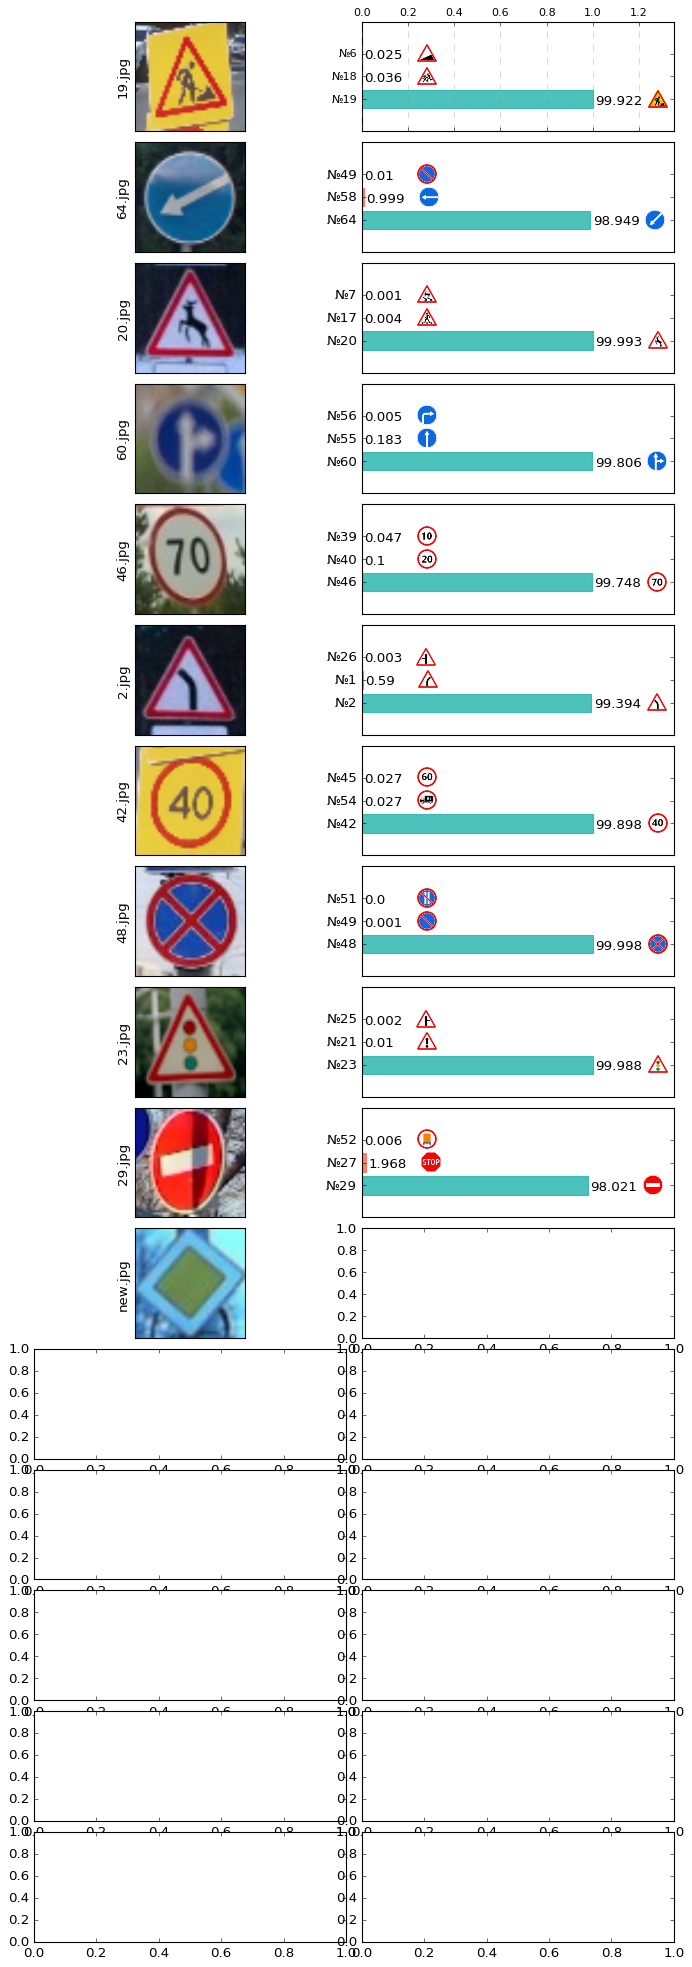

In [0]:
import os

orig_signs_folder_path = '/content/drive/My Drive/Colab Notebooks/Bases/signs_original'
examples_path = '/content/drive/My Drive/Colab Notebooks/Bases/signs_classification_examples/'
examples_names = np.asarray(os.listdir(examples_path), dtype=np.str)

n_examples = examples_names.shape[0]
example_X_paths = np.core.defchararray.add(examples_path, examples_names)

example_X = load_data(example_X_paths, width, height)

pred_examples_outputs = model.predict(example_X)
pred_examples_labels = np.argmax(pred_examples_outputs, axis=1)

fig, axes = plt.subplots(nrows=n_examples, ncols=2, 
                         figsize=(8, n_examples*2))

fig.subplots_adjust(left=0, right=1, bottom=0.2, top=0.95, hspace=0.1, wspace=0.05)
plt.style.use(['classic'])
fig.set_facecolor('w')

for i_row in range(n_examples):

    df_class = pd.DataFrame(data=pred_examples_outputs[i_row],
                            index=range(n_classes))

    df_class = df_class.sort_values(0, ascending=False).head(3)

    for i_col in range(2):

        ax = axes[i_row, i_col]

        if i_col == 0:
            ax.imshow(example_X[i_row])
            ax.set_ylabel(examples_names[i_row])
            ax.set_xticks([])
            ax.set_yticks([])

        else:
            plot_fancy_signs_bar(df_class, orig_signs_folder_path, ax, xlims=[0, 1],
                                 delta_w = 0.28, x_increase=1.35, zoom=0.35,
                                 green_condition=[int(examples_names[i_row].split(sep='.')[0])])
            
            if i_row == 0:
                ax.tick_params(labeltop=True, labelbottom=False, labelsize=10)
            elif i_row == n_examples-1:
                ax.tick_params(bottom=True, labeltop=False, labelsize=10)
            else:
                ax.set_xticks([])


# plt.suptitle('Классификация новых изображений дорожных знаков', color='k', fontsize=16,
#              alignment='right')
# plt.ylabel('Номер класса дорожного знака', color='k', fontsize=16)
# plt.xlabel('Кол-во фото', color='k', fontsize=16)
fig.savefig(results_path + '/results_examples_1.png', dpi = 400)

(76, 48, 48, 3)


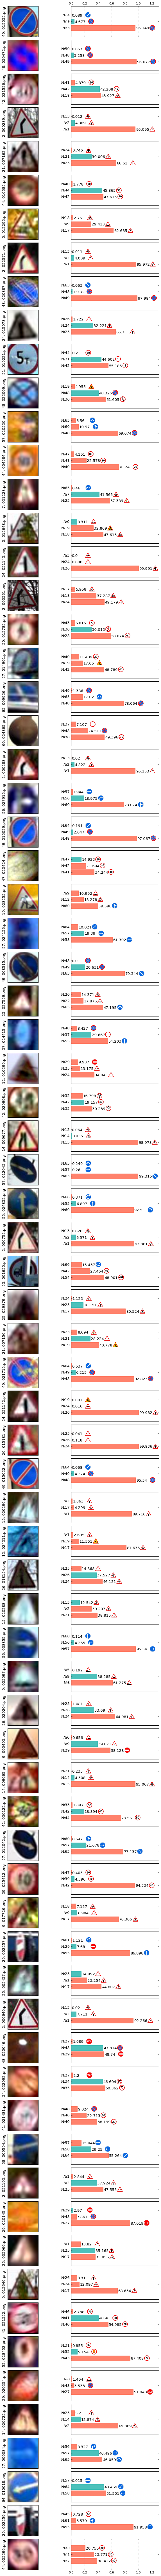

In [0]:
orig_signs_folder_path = '/content/drive/My Drive/Colab Notebooks/Bases/signs_original'

v_pred_classes = model.predict_classes(val_X)  

# номер изображения, где 
img_labels = np.argmax(val_Y, axis=1)

# индексы неверно распознаных изображений
incorrect_classes = np.where(v_pred_classes != img_labels)[0]
print(val_X[incorrect_classes].shape)

# выборка (неверно определенных) изображений и их распознанных классов
example_X = val_X[incorrect_classes] 
example_Y = img_labels[incorrect_classes]
# print(example_X.shape)

n_examples = example_X.shape[0]
pred_examples_outputs = model.predict(example_X)
# print(pred_examples_outputs.shape)

incorrect_file_paths = val_X_paths[incorrect_classes]
file_names = []
for row in incorrect_file_paths:
    file_names.append(row.split('/')[-1])
# pred_examples_labels = np.argmax(pred_examples_outputs, axis=1)
# plt.imshow(example_X[0])
fig, axes = plt.subplots(nrows=n_examples, ncols=2, 
                         figsize=(8, n_examples*2))

fig.subplots_adjust(left=0, right=1, bottom=0.2, top=0.95, hspace=0.1, wspace=0.05)
plt.style.use(['classic'])
fig.set_facecolor('w')

for i_row in range(n_examples):

    df_class = pd.DataFrame(data=pred_examples_outputs[i_row],
                            index=range(n_classes))

    df_class = df_class.sort_values(0, ascending=False).head(3)

    for i_col in range(2):

        ax = axes[i_row, i_col]

        if i_col == 0:
            # print(example_X[i_row])
            ax.imshow(example_X[i_row])
            ax.set_ylabel(str(example_Y[i_row]) + ': ' + file_names[i_row])
            ax.set_xticks([])
            ax.set_yticks([])

        else:

            plot_fancy_signs_bar(df_class, orig_signs_folder_path, ax, xlims=[0, 1],
                                 delta_w = 0.25, x_increase=1.3, zoom=0.35,
                                 green_condition=[example_Y[i_row]]) 
            
            if i_row == 0:
                ax.tick_params(labeltop=True, labelbottom=False, labelsize=10)
            elif i_row == n_examples-1:
                ax.tick_params(bottom=True, labeltop=False, labelsize=10)
            else:
                ax.set_xticks([])


# plt.suptitle('Классификация новых изображений дорожных знаков', color='k', fontsize=16,
#              alignment='right')
# plt.ylabel('Номер класса дорожного знака', color='k', fontsize=16)
# plt.xlabel('Кол-во фото', color='k', fontsize=16)
fig.savefig(results_path + '/incorrect_results_examples_new.png', dpi = 100)

In [0]:
# val_X_paths[incorrect_classes]
# str.split()
# incorrect_file_paths = val_X_paths[incorrect_classes]
# file_names = []
# for row in file_paths:
#     file_names.append(row.split('/')[-1])
# print(file_names)
# print([row in val_X_paths[incorrect_classes] row.split(sep='/')])
# print(incorrect_classes)
# print(file_names)

to_change_label = {2: 49, 4: 1, 8: 1, 17: 26, 23: 1, 34: 15, 37: 1, 42: 26, 53: 15, 60: 1}
for index, label in to_change_label.items():
    # print(label, file_names[index-1])
    ind = incorrect_classes[index-1]
    # print(ind)
    # print(val_Y[ind])
    # print(label)
    # print(to_categorical(label, num_classes=n_classes))

    val_Y[ind] = to_categorical(label, num_classes=n_classes)
# plt.imshow(val_X[667])
# # print(file_names[0], file_names[24], file_names[-33])
to_hor_flip = [0, 24, -33]
for index in to_hor_flip:
    ind = incorrect_classes[index]
#     # print(ind)
    val_X[ind] = np.fliplr(val_X[ind])


In [0]:
# val_X.shape
val_eval = model.evaluate(val_X, val_Y)
print(f'loss: {round(val_eval[0], 5)}, acc: {round(val_eval[1], 5)}')

9895/9895 [==============================] - 1s 125us/step
loss: 0.02339, acc: 0.99363
